In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier


In [4]:
def load_dataset(data_dir, img_width=92, img_height=112):
    X, y = [], []
    for folder in sorted(os.listdir(data_dir)):
        subject_path = os.path.join(data_dir, folder)
        if not os.path.isdir(subject_path):
            continue
        
        label = int(folder[1:])  # Convert s1 → 1
        for img_file in sorted(os.listdir(subject_path)):
            img_path = os.path.join(subject_path, img_file)
            img = Image.open(img_path).convert("L")  # Grayscale
            img = img.resize((img_width, img_height))
            img_array = np.array(img, dtype=np.float64).flatten()
            X.append(img_array)
            y.append(label)
    return np.array(X), np.array(y)

# Set dataset path
DATA_DIR = "att_faces"
X, y = load_dataset(DATA_DIR)
print(f"Dataset Loaded: {X.shape[0]} images, {X.shape[1]} pixels each")


Dataset Loaded: 400 images, 10304 pixels each


In [6]:
def pca(X, num_components):
    mean_face = np.mean(X, axis=0)
    X_centered = X - mean_face

    # Small covariance trick
    cov_matrix = np.dot(X_centered, X_centered.T)

    eigenvalues, eigenvectors_small = np.linalg.eigh(cov_matrix)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors_small = eigenvectors_small[:, idx]

    # Map eigenvectors to original space
    eigenfaces = np.dot(X_centered.T, eigenvectors_small)
    eigenfaces = eigenfaces / np.linalg.norm(eigenfaces, axis=0)

    return mean_face, eigenfaces[:, :num_components]


In [7]:
def project_images(X, mean_face, eigenfaces):
    return np.dot(X - mean_face, eigenfaces)

def reconstruct_images(projections, mean_face, eigenfaces):
    return np.dot(projections, eigenfaces.T) + mean_face


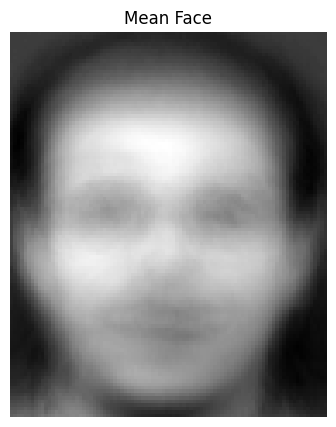

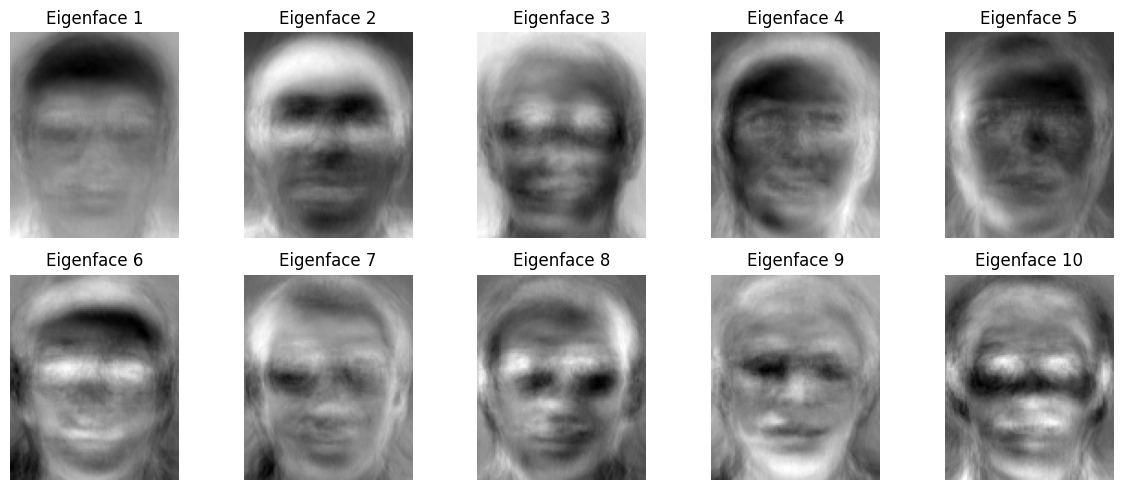

In [8]:
def show_image(image, title=""):
    plt.imshow(image.reshape(112, 92), cmap="gray")
    plt.title(title)
    plt.axis("off")

# Apply PCA on training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
mean_face, eigenfaces = pca(X_train, 100)

# Show Mean Face
plt.figure(figsize=(5,5))
show_image(mean_face, "Mean Face")
plt.show()

# Show First 10 Eigenfaces
plt.figure(figsize=(12,5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    show_image(eigenfaces[:, i], title=f"Eigenface {i+1}")
plt.tight_layout()
plt.show()


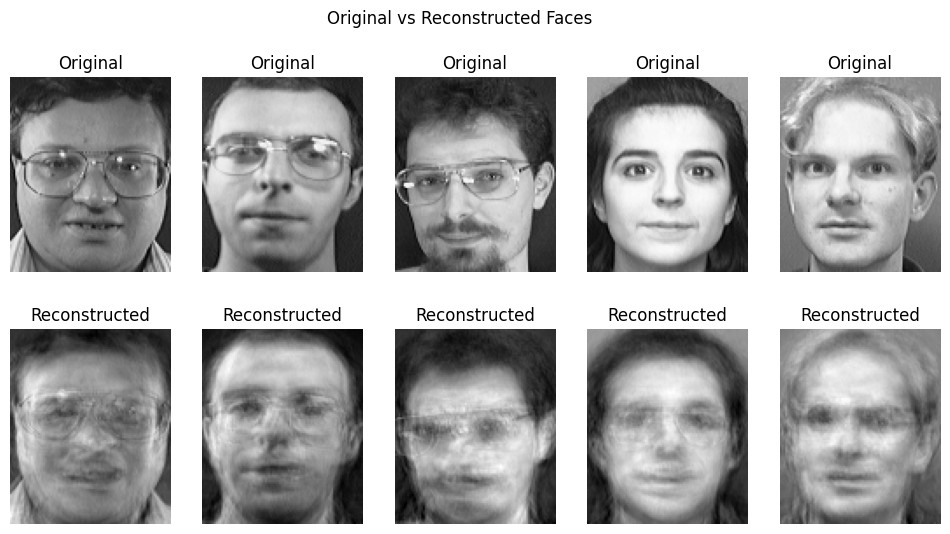

In [9]:
projections = project_images(X_test, mean_face, eigenfaces)
reconstructed = reconstruct_images(projections, mean_face, eigenfaces)

plt.figure(figsize=(12,6))
for i in range(5):
    plt.subplot(2,5,i+1)
    show_image(X_test[i], "Original")
    plt.subplot(2,5,i+6)
    show_image(reconstructed[i], "Reconstructed")
plt.suptitle("Original vs Reconstructed Faces")
plt.show()


Components: 10, Accuracy: 0.9667
Components: 20, Accuracy: 0.9750
Components: 30, Accuracy: 0.9750
Components: 40, Accuracy: 0.9667
Components: 50, Accuracy: 0.9917
Components: 60, Accuracy: 0.9750
Components: 70, Accuracy: 0.9750
Components: 80, Accuracy: 0.9750
Components: 90, Accuracy: 0.9667
Components: 100, Accuracy: 0.9667
Components: 110, Accuracy: 0.9667
Components: 120, Accuracy: 0.9667
Components: 130, Accuracy: 0.9667
Components: 140, Accuracy: 0.9583


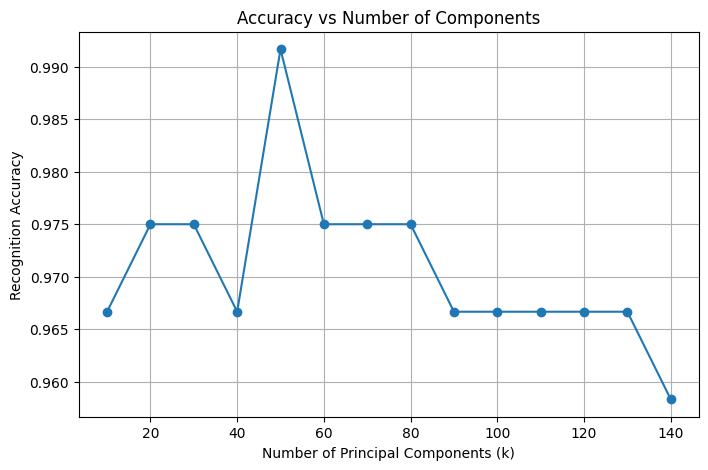

In [10]:
k_values = list(range(10, 150, 10))
accuracies = []

for k in k_values:
    mean_face, eigenfaces_k = pca(X_train, k)
    X_train_proj = project_images(X_train, mean_face, eigenfaces_k)
    X_test_proj = project_images(X_test, mean_face, eigenfaces_k)
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train_proj, y_train)
    acc = knn.score(X_test_proj, y_test)
    accuracies.append(acc)
    print(f"Components: {k}, Accuracy: {acc:.4f}")

plt.figure(figsize=(8,5))
plt.plot(k_values, accuracies, marker="o")
plt.xlabel("Number of Principal Components (k)")
plt.ylabel("Recognition Accuracy")
plt.title("Accuracy vs Number of Components")
plt.grid()
plt.show()
